**1.  Appling Gauss Kronrod Quadrature for high-rank variable**

Apply quadgk for high rank core \
size=(full-rank, N, half-rank)

$$
\begin{split}
f(jl;k) &= \cos{(2 \pi \frac{jk}{N})} \cdot \sin{(2 \pi \frac{jl}{N})} \cdot e^{-\frac{j}{N}} \\ &+ \sin{(2 \pi \frac{jk}{N})} \cdot \cos(2 \pi \frac{jl}{N}) \cdot e^{-\frac{j^2}{N^2}}
\end{split}
$$


In [ ]:
using QuadGK

j = 1
l = 1
function f(k)
    term1 = cos(2*π*(j*k)) * sin(2*π*(j*l))* exp(-j)
    term2 = sin(2*π*(j*k)) * cos(2*π*(j*l))* exp(-j^2)
    return term1 + term2
end

function g(k)
    term1 = cos(k) * sin(1)* exp(-1)
    term2 = sin(k) * cos(1)* exp(-1)
    return term1 + term2
end
#Using Gauss Kronrod quadrature
integral, err = quadgk(k -> g(k), 0, 1, rtol=1e-8)

println(integral)


0.3518579760206393


<img src="Image/quadgk.png" alt="std" width=800>

**2. Integral based on TCI**

<img src="Image/IntegralTCI.jpg" alt="std" width=800>

In [10]:
# pkg import
import TensorCrossInterpolation as TCI
using Random

#TCI
N::Int = 100

function f(v)
    j = v[1]
    k = v[2]
    l = v[3]
    term1 = cos(2*π*(j*k/N)) * sin(2*π*(j*l/N))* exp(-j/N)
    term2 = sin(2*π*(j*k/N)) * cos(2*π*(j*l/N))* exp(-j^2/N^2)
    return term1 + term2
end

localdims = fill(N, 3) # N lattices for 3 variable
tolerance = 1e-8 #target error
tci, ranks, errors = TCI.crossinterpolate2(Float64, f, localdims; tolerance=tolerance)

mps = tci.sitetensors


j = 10
l = 10
idxLst = collect(1:N)
result = 0
for k in idxLst
    result += (mps[1][:,j,:] * mps[2][:,k,:] * mps[3][:,l,:])[1]
end

println("TCI sum ", result)

TCI sum -6.315961348551776e-15


**3. Integral based on Monte Carlo** \
Q. what is the formula for calulating error?

TensorCrossInterpolation.TensorCI2{Float64} with rank 100
4.3763843870497915e-16


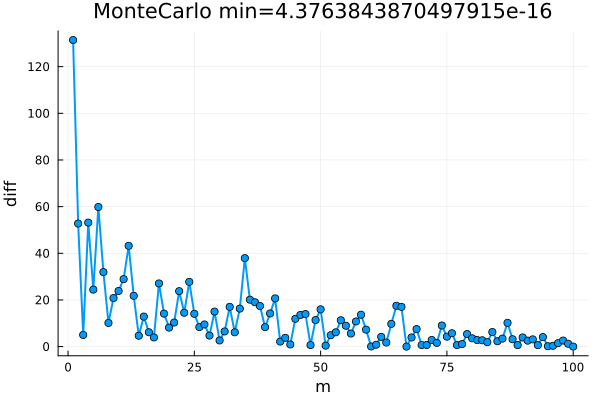

In [15]:
# pkg import
import TensorCrossInterpolation as TCI
using Random

#TCI
N::Int = 100

function f(v)
    j = v[1]
    k = v[2]
    l = v[3]
    term1 = cos(2*π*(j*k/N)) * cos(2*π*(j*l/N))* exp(-j/N)
    term2 = sin(2*π*(j*k/N)) * cos(2*π*(j*l/N))* exp(-j^2/N^2)
    return term1 + term2
end

localdims = fill(N, 3) # N lattices for 3 variable
tolerance = 1e-8 #target error
tci, ranks, errors = TCI.crossinterpolate2(Float64, f, localdims; tolerance=tolerance)

println(tci)

mps = tci.sitetensors

diff = [] #not error! -> How can i measure error??
for m in 1:100
    #set sum range
    j = 10
    randIdxK = shuffle(collect(1:N))[1:m] #generate 20 random numbers
    l = 10

    SliceJ = mps[1][:,j,:]
    SliceL = mps[3][:,l,:]

    #monte carlo
    mcSliceK = zeros(size(mps[2][:,1,:])) #zero matrix for sum

    for k in randIdxK
        mcSliceK += mps[2][:,k,:]
    end

    mcSliceK = (N / m) * mcSliceK 

    mcResult = SliceJ * mcSliceK * SliceL
    #println("MonteCarlo Sum ", mcResult[1])

    #Exact sum
    exactSliceK = zeros(size(mps[2][:,1,:]))

    for k in 1:N
        exactSliceK += mps[2][:,k,:] #sum of all indices
    end

    exactResult = SliceJ * exactSliceK * SliceL
    #println("Exact Sum ", exactResult[1])

    push!(diff,abs(mcResult[1]-exactResult[1]))
end

minVal = minimum(diff)
println(minVal)
plot(diff,
    title="MonteCarlo min=$minVal",
    xlabel="m",
    ylabel="diff",
    label="",
    linewidth=2,
    marker=:circle
)



**4. Error Estimate for Monte Carlo Method** 

Q. How can we define 'standard deviation of matrices'? 

*Cat function of julia : https://juliakorea.github.io/ko/latest/manual/arrays/#%EB%B3%91%ED%95%A9(Concatenation)-1 \
*Get std along the specific dimension : https://www.jlhub.com/julia/manual/en/function/std

<img src="Image/std.jpg" alt="std" width=800>

TensorCrossInterpolation.TensorCI2{Float64} with rank 100


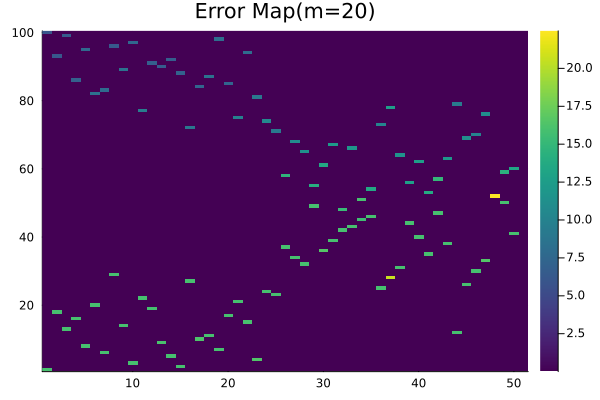

In [ ]:
# pkg import
import TensorCrossInterpolation as TCI
using Random
using Plots
using Statistics

#TCI
N::Int = 100

function f(v)
    j = v[1]
    k = v[2]
    l = v[3]
    term1 = cos(2*π*(j*k/N)) * cos(2*π*(j*l/N))* exp(-j/N)
    term2 = sin(2*π*(j*k/N)) * cos(2*π*(j*l/N))* exp(-j^2/N^2)
    return term1 + term2
end

localdims = fill(N, 3) # N lattices for 3 variable
tolerance = 1e-8 #target error
tci, ranks, errors = TCI.crossinterpolate2(Float64, f, localdims; tolerance=tolerance)

println(tci)

mps = tci.sitetensors

#Get standard deviation for each elements
sliceKs = [mps[2][:, k, :] for k in 1:N]

(rows, cols) = size(sliceKs[1])
stdMatrix = zeros(Float64, rows, cols)

for j in 1:rows
    for l in 1:cols
        lineJL = [sliceK[j,l] for sliceK in sliceKs]
        stdMatrix[j,l] = std(lineJL)
    end
end
errMatrix = (stdMatrix / sqrt(m)) * N

#visualize
heatmap(errMatrix, color=:viridis, title="Error Map(m=$m)")


**5. Markov Chain Monte-Carlo, Metropolis-Hastings algorithm**

**6. Importance Sampling**